# **응급상황 자동 인식 및 응급실 연계 서비스**
# 단계2 : 파인튜닝!

## **0.미션**

### (1) 미션1
단계 2에서는 사전 학습된 한국어 BERT 모델을 다운받아, 파인튜닝을 시도합니다. 이를 위해 먼저 적절한 데이터를 수집해야 합니다.

* 학습 데이터 준비
    * 등급별 50개씩 샘플 데이터를 제공합니다.
    * **응급상황 등급(1~5) 별 최소 100건씩** 데이터를 추가로 수집(제작)하세요.
        * 중증도 카테고리 파일에 있는 키워드 참조
        * 제작시 GPT를 적극 활용해 봅시다.
    * 총 데이터 크기 : 600건
        * 제공데이터 100건(20건씩 5개 등급)
        * 추가 제작 500건(100건씩 5개 등급)

|text|label|
|----|----|
|GPT모델의 출력 형태. 응급상황 내용 | 응급등급(1~5)|



### (1) 라이브러리 설치 및 로딩

In [ ]:
!pip install datasets

* (필요 시) 설치 후 세션 다시 시작

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성
    * evaluate : 모델 생성후, 데이터셋(예 : 검증셋)을 이용해서 모델 성능을 평가하기 위한 용도
    * predict :  하나의 문장을 입력받아, 예측결과를 반환

In [ ]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [ ]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = ''

### (3) 데이터 로딩
* 이전 미션에서 준비한 데이터셋을 로딩합니다.

In [ ]:
label_class = pd.read_csv(path + '중증도 카테고리.csv', encoding='euc-kr')
label_class

,구분1,구분2,구분3,등급
0,물질오용,물질오용/중독,중증 호흡곤란,1
1,물질오용,물질오용/중독,쇼크,1
2,물질오용,물질오용/중독,무의식(GCS 3-8),1
3,물질오용,물질오용/중독,중등도 호흡곤란,2
4,물질오용,물질오용/중독,혈역학적 장애,2
...,...,...,...,...
2024,일반,경증 호소,만성 말초성 중증 통증(8-10),4
2025,일반,경증 호소,만성 중심성 경증 통증(<4),5
2026,일반,경증 호소,급성 말초성 경증 통증(<4),5
2027,일반,경증 호소,만성 말초성 통증(<8),5


In [ ]:
data =  pd.read_csv(path + "df_basic_true.csv")
data

,기관명,기관주소,위도,경도
0,(의)내경의료재단울산제일병원,울산광역시 남구 남산로354번길 26 (신정동),35.548238,129.307011
1,(의)서일의료재단기장병원,부산광역시 기장군 기장읍 대청로72번길 6,35.236029,129.216492
2,(의)성세의료재단 뉴성민병원,"인천광역시 서구 칠천왕로33번길 17 (석남동, 신석로 70(석남1동, 성민병원))",37.508994,126.669479
3,(의)영문의료재단다보스병원,"경기도 용인시 처인구 백옥대로1082번길 18, 다보스종합병원 (김량장동)",37.234641,127.210499
4,(의)효심의료재단용인서울병원,경기도 용인시 처인구 고림로 81 (고림동),37.240316,127.214491
...,...,...,...,...
521,효산의료재단안양샘병원,"경기도 안양시 만안구 삼덕로 9 (안양동, 안양샘병원)",37.393404,126.924477
522,효산의료재단지샘병원,"경기도 군포시 군포로 591 (당동, (G샘병원)군포샘병원)",37.358645,126.947360
523,효성시티병원,부산광역시 해운대구 해운대로 135 (재송동),35.185413,129.121459
524,흑룡의원,인천광역시 옹진군 백령면 백령로 831,37.959524,124.665499


In [ ]:
data = pd.read_csv(path + 'dataset.csv')
data.head()

,text,label
0,환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태,1
1,환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 않는 쇼크 상태,1
2,"환자가 바닥에 쓰러져 의식을 잃었고, 주변의 소리에 반응하지 않으며, 몸이 움직이지...",1
3,환자가 심한 호흡곤란으로 숨을 쉬지 못해 곤란해하는 상태,1
4,환자가 심각한 쇼크로 인해 혈압이 떨어지고 의식을 잃을 위험에 있는 상태,1


In [ ]:
# 중증도 카테고리를 gpt를 이용하여 분류하고 상황 생성
generated_emergency_data_text_label = pd.read_csv(path + "cleaned_combined_emergency_data.csv")
generated_emergency_data_text_label

,label,text
0,1,급성 뇌경색으로 인해 말이 어눌해지고 팔다리 마비가 동반된 상황 상태에서 의식수준의...
1,1,뇌출혈로 인해 갑작스러운 의식 저하와 구토가 발생한 상황 상태에서 의식수준의 변화 ...
2,1,편두통 악화로 인해 극심한 두통과 시야 흐림이 발생한 상황 상태에서 의식수준의 변화...
3,2,간질 발작으로 인해 의식을 잃고 경련이 동반된 상황 상태에서 의식수준의 변화 상황이...
4,2,치매로 인해 기억력 저하와 혼란스러운 행동이 나타난 상황 상태에서 의식수준의 변화 ...
...,...,...
1896,3,열사병으로 인해 의식 저하와 탈수가 심화된 상황 상태에서 익수 상황이 경증 호흡곤란...
1897,3,저체온증으로 인해 의식이 흐려지고 떨림이 동반된 상황 상태에서 익수 상황이 비정상 ...
1898,3,화학물질 노출로 인해 피부 발진과 호흡 곤란이 발생한 상황 상태에서 익수 상황이 열...
1899,2,전기 화상으로 인해 피부 손상과 근육 경련이 동반된 상황 상태에서 익수 상황이 저체...


In [ ]:
data = pd.concat((data, generated_emergency_data_text_label), ignore_index=True)
data

,text,label
0,환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태,1
1,환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 않는 쇼크 상태,1
2,"환자가 바닥에 쓰러져 의식을 잃었고, 주변의 소리에 반응하지 않으며, 몸이 움직이지...",1
3,환자가 심한 호흡곤란으로 숨을 쉬지 못해 곤란해하는 상태,1
4,환자가 심각한 쇼크로 인해 혈압이 떨어지고 의식을 잃을 위험에 있는 상태,1
...,...,...
1996,열사병으로 인해 의식 저하와 탈수가 심화된 상황 상태에서 익수 상황이 경증 호흡곤란...,3
1997,저체온증으로 인해 의식이 흐려지고 떨림이 동반된 상황 상태에서 익수 상황이 비정상 ...,3
1998,화학물질 노출로 인해 피부 발진과 호흡 곤란이 발생한 상황 상태에서 익수 상황이 열...,3
1999,전기 화상으로 인해 피부 손상과 근육 경련이 동반된 상황 상태에서 익수 상황이 저체...,2


* y 분포 확인하기

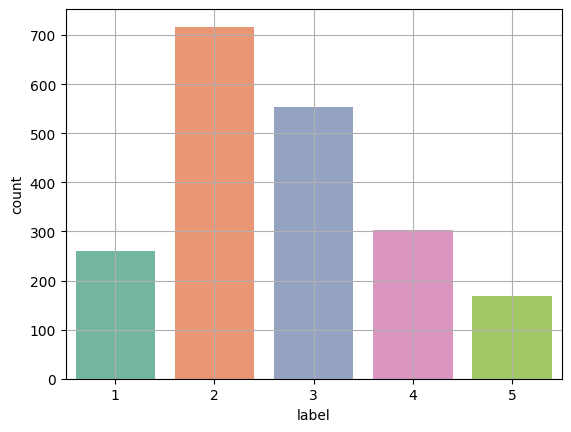

In [ ]:
sns.countplot(x='label', data = data, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

,text,label
0,환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태,0
1,환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 않는 쇼크 상태,0
2,"환자가 바닥에 쓰러져 의식을 잃었고, 주변의 소리에 반응하지 않으며, 몸이 움직이지...",0
3,환자가 심한 호흡곤란으로 숨을 쉬지 못해 곤란해하는 상태,0
4,환자가 심각한 쇼크로 인해 혈압이 떨어지고 의식을 잃을 위험에 있는 상태,0


### (4) GPU 설정
* 파이토치를 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [ ]:
# 데이터셋 분할
train, val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# 텐서 데이터셋으로 변환
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

In [ ]:
train_ds[:3]

{'text': ['녹내장으로 인해 시야 흐림과 심한 눈 통증이 동반된 상황 상태에서 화학물질 노출,눈 상황이 화학물질 노출,눈로 이어짐',
  '골절로 인해 부종과 심한 통증이 동반된 상황 상태에서 요통 상황이 급성 중심성 경증 통증(<4)로 이어짐',
  '간염으로 황달과 피로감이 나타난 상황 상태에서 황달 상황이 중등도 호흡곤란로 이어짐'],
 'label': [1, 3, 1],
 '__index_level_0__': [240, 1669, 692]}

### (2) 토큰화

* 사용할 모델("klue/bert-base")의 토크나이저를 저장

In [ ]:
# 모델과 토크나이저 불러오기
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# 토큰화 함수 생성 및 적용
def preprocess_function(data):
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비
* 사용할 모델("klue/bert-base")의 토크나이저를 저장
* 이때, 출력층 노드 수를 지정합니다.

In [ ]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = n).to(device)

### (2) 학습

In [ ]:
# TrainingArguments

lr = 0.0001
batch_size = 32
epochs = 20

training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs  = epochs,
    weight_decay = 0.02,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    logging_steps = 10,                # 로깅 스텝
    report_to="tensorboard"          # TensorBoard에 로깅
)

In [ ]:
# Trainer 설정
patience =  5      # <--

trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)], # 조기 종료
)

In [ ]:
# 모델 학습
trainer.train()

In [ ]:
# 모델 평가
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

### (3) 모델 검증평가
* evaluate 함수를 이용해서 검증셋에 대한 성능 평가를 수행합니다.

In [ ]:
pred, prob = evaluate(val_ds, model, device, tokenizer)

In [ ]:
print(confusion_matrix(val_ds['label'], pred))
print(classification_report(val_ds['label'], pred))

[[ 60   0   3   0   0]
 [  1 127   4   3   0]
 [  1   3 107   1   2]
 [  1   1   3  50  12]
 [  0   0   0   2  20]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        63
           1       0.97      0.94      0.95       135
           2       0.91      0.94      0.93       114
           3       0.89      0.75      0.81        67
           4       0.59      0.91      0.71        22

    accuracy                           0.91       401
   macro avg       0.86      0.90      0.87       401
weighted avg       0.92      0.91      0.91       401



### (4) 모델 사용
* 응급상황에 대한 샘플 문자을 넣고 등급을 적절히 분류하는지 눈으로 확인해 봅시다.

In [ ]:
text = "환자가 심한 호흡곤란을 겪고 있으며 얼굴이 창백해지고 식은땀을 흘리며 의식이 혼미해지고 있습니다."
predicted_class, probabilities = predict(text, model, tokenizer)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {le.inverse_transform([predicted_class])}")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 0
예측된 클래스 이름: [1]
클래스별 확률: tensor([[0.6975, 0.0138, 0.2766, 0.0060, 0.0060]], device='cuda:0')


## 4.모델 저장

### (1) 모델 저장
* save_pretrained 메서드를 사용해 모델과 토크나이저를 디렉토리에 저장합니다.
* 저장 대상 : 모델, 토크나이저

In [ ]:
# 모델과 토크나이저 저장 경로 : 폴더가 없으면, fine_tuned_bert를 생성
save_directory = path + "fine_tuned_bert_3"

# 모델 저장
model.save_pretrained(save_directory)

# 토크나이저도 함께 저장
tokenizer.save_pretrained(save_directory)

### (2) 모델 로딩 및 사용
* 저장한 모델을 나중에 다시 불러와 예측이나 추가 작업에 사용할 수 있습니다. Hugging Face from_pretrained 메서드를 사용하여 저장 경로에서 모델과 토크나이저를 로드합니다.
* 로딩 대상 : 모델, 토크나이저

In [ ]:
# 모델 로드
model2 = AutoModelForSequenceClassification.from_pretrained(save_directory)

# 토크나이저 로드
tokenizer2 = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
# 모델을 GPU로 이동 (필요한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

In [ ]:
text = "넘어졌는데, 지금 출혈이 있고, 머리가 어지럽습니다."
predicted_class, probabilities = predict(text, model2, tokenizer2)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {predicted_class+1}등급")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 2
예측된 클래스 이름: 3등급
클래스별 확률: tensor([[0.1104, 0.3750, 0.4383, 0.0703, 0.0060]], device='cuda:0')


## 하이퍼 파라미터 튜닝

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
# {'learning_rate': 3.2062151872186694e-05, 'batch_size': 32, 'epochs': 24

In [ ]:
import optuna
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch

def objective(trial):
    # Optuna를 통해 하이퍼파라미터 샘플링
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 20, 30)

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.02,
        load_best_model_at_end=True,
        logging_dir='./logs',
        logging_steps=10,
        report_to="tensorboard",
    )

    # Trainer 설정
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    # 모델 학습
    trainer.train()

    # 최종 평가 지표로 사용할 메트릭 반환
    eval_results = trainer.evaluate()
    return eval_results['eval_loss']

# Optuna Study 생성 및 최적화 수행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-11-19 06:13:59,311] A new study created in memory with name: no-name-abbd9b0e-8a73-4f9c-b67f-68381e10c90b


Epoch,Training Loss,Validation Loss
1,No log,0.617784
2,0.023200,0.506396
3,0.005800,0.517545
4,0.001600,0.532908
5,0.001300,0.542992
6,0.001300,0.550005
7,0.001000,0.555461


[I 2024-11-19 06:17:31,254] Trial 0 finished with value: 0.5063959360122681 and parameters: {'learning_rate': 1.155136831609635e-05, 'batch_size': 64, 'epochs': 27}. Best is trial 0 with value: 0.5063959360122681.


Epoch,Training Loss,Validation Loss
1,0.055400,1.002259
2,0.311100,1.269820
3,0.292800,0.527556
4,0.056400,0.586251
5,0.054300,0.509990
6,0.034000,0.567802
7,0.051000,0.703554
8,0.052000,0.459115
9,0.002400,0.615839
10,0.020400,0.657265


[I 2024-11-19 06:25:36,552] Trial 1 finished with value: 0.42325013875961304 and parameters: {'learning_rate': 0.00014145732315677803, 'batch_size': 32, 'epochs': 30}. Best is trial 1 with value: 0.42325013875961304.


Epoch,Training Loss,Validation Loss
1,0.352700,1.524420
2,0.428000,0.746639
3,0.439100,1.380562
4,0.834500,0.683772
5,0.444300,0.538802
6,0.206900,0.687407
7,0.130400,0.487081
8,0.248400,0.494140
9,0.651500,0.807239
10,0.394800,1.102420


[I 2024-11-19 06:31:08,449] Trial 2 finished with value: 0.4870811104774475 and parameters: {'learning_rate': 0.00017448368956035932, 'batch_size': 16, 'epochs': 30}. Best is trial 1 with value: 0.42325013875961304.


Epoch,Training Loss,Validation Loss
1,0.021800,0.479013
2,0.078700,0.373059
3,0.228100,0.557633
4,0.008100,0.612001
5,0.023200,0.496590
6,0.037900,0.391847
7,0.042600,0.423163


[I 2024-11-19 06:34:49,646] Trial 3 finished with value: 0.37305933237075806 and parameters: {'learning_rate': 3.2062151872186694e-05, 'batch_size': 32, 'epochs': 24}. Best is trial 3 with value: 0.37305933237075806.


Epoch,Training Loss,Validation Loss
1,No log,1.843682
2,1.796000,1.476714
3,1.539900,1.473175
4,1.598500,1.638043
5,1.635400,1.603047
6,1.635400,1.643890
7,1.644500,1.615169
8,1.635400,1.601985


[I 2024-11-19 06:38:45,567] Trial 4 finished with value: 1.4731754064559937 and parameters: {'learning_rate': 0.0006537620123225382, 'batch_size': 64, 'epochs': 20}. Best is trial 3 with value: 0.37305933237075806.


Epoch,Training Loss,Validation Loss
1,1.573900,1.592382
2,1.559200,1.577672
3,1.561400,1.566741
4,1.473800,1.502516
5,1.447100,1.496662
6,1.448500,1.444639
7,1.486700,1.389483
8,1.299900,1.376022
9,1.380000,1.379366
10,1.299900,1.378925


[I 2024-11-19 06:46:04,508] Trial 5 finished with value: 1.3760221004486084 and parameters: {'learning_rate': 3.077835610490103e-05, 'batch_size': 16, 'epochs': 30}. Best is trial 3 with value: 0.37305933237075806.


Epoch,Training Loss,Validation Loss
1,No log,2.110141
2,2.276200,1.644594
3,1.690100,1.664307
4,1.677400,1.610323
5,1.654400,1.604433
6,1.654400,1.641160
7,1.639000,1.619862
8,1.647200,1.641978
9,1.688900,1.640834
10,1.634800,1.607637


[I 2024-11-19 06:52:00,321] Trial 6 finished with value: 1.6044331789016724 and parameters: {'learning_rate': 0.0006985356197406934, 'batch_size': 64, 'epochs': 24}. Best is trial 3 with value: 0.37305933237075806.


Epoch,Training Loss,Validation Loss
1,1.639100,1.617304
2,1.629600,1.614566
3,1.630700,1.611068
4,1.624000,1.627986
5,1.616700,1.617580
6,1.631000,1.608779
7,1.626500,1.631021
8,1.637600,1.609090
9,1.621700,1.629020
10,1.627800,1.612688


[I 2024-11-19 06:57:19,357] Trial 7 finished with value: 1.6087791919708252 and parameters: {'learning_rate': 0.00013051164847536345, 'batch_size': 32, 'epochs': 27}. Best is trial 3 with value: 0.37305933237075806.


Epoch,Training Loss,Validation Loss


[W 2024-11-19 06:57:21,255] Trial 8 failed with parameters: {'learning_rate': 0.00024649306658785445, 'batch_size': 64, 'epochs': 20} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-ef8a65990786>", line 40, in objective
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2123, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2486, in _inner_training_loop
    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
KeyboardInterrupt
[W 2024-11-19 06:57:21,257] Trial 8 failed with value None.


KeyboardInterrupt: 